# Gene Expression-Based Prediction of Breast Cancer Subtypes Using Random Forest Algorithms

Load and prepare data

In [1]:
import pandas as pd

# Load gene expression data
gene_expression_file = '/Users/christophertarkaa/Downloads/brca_metabric/data_mrna_illumina_microarray_zscores_ref_diploid_samples.txt'
gene_expression_data = pd.read_csv(gene_expression_file, sep='\t')

In [2]:
# Load clinical data
clinical_data_file = '/Users/christophertarkaa/Downloads/brca_metabric/data_clinical_sample.txt'
clinical_data = pd.read_csv(clinical_data_file, sep='\t')

In [3]:
# Display first few rows of each dataframe to understand their structure
print(gene_expression_data.head())
print(clinical_data.head())

  Hugo_Symbol  Entrez_Gene_Id  MB-0362  MB-0346  MB-0386  MB-0574  MB-0185  \
0        RERE             473  -0.7139   1.2266  -0.0053  -0.4399  -0.5958   
1      RNF165          494470  -0.4606   0.3564  -0.6800  -1.0563  -0.0377   
2        PHF7           51533  -0.3325  -1.0617   0.2587  -0.2982  -1.2422   
3       CIDEA            1149  -0.0129  -1.0394   3.2991  -0.2632  -1.0949   
4       TENT2          167153  -0.7853   0.0337  -0.6649   2.1640  -0.2031   

   MB-0503  MB-0641  MB-0201  ...  MB-6192  MB-4820  MB-5527  MB-5167  \
0   0.4729   0.4974  -1.1900  ...  -0.4596   1.8975   1.1120   1.1942   
1  -0.6829  -0.2854  -0.4336  ...  -1.0927   0.9103  -0.0023  -0.2898   
2   0.0558  -0.5011  -0.6418  ...  -0.0725   0.7219   0.1402   0.8718   
3   1.2628   2.0796  -0.8310  ...   0.0679  -0.7126  -0.1523  -0.7593   
4   1.0304   0.6046  -1.7557  ...   0.6400  -0.1102   1.2719   0.8178   

   MB-5465  MB-5453  MB-5471  MB-5127  MB-4313  MB-4823  
0  -1.7974   1.1339   0.0259  -0.3

In [4]:
# Check column names for common identifier
print(gene_expression_data.columns)
print(clinical_data.columns)

Index(['Hugo_Symbol', 'Entrez_Gene_Id', 'MB-0362', 'MB-0346', 'MB-0386',
       'MB-0574', 'MB-0185', 'MB-0503', 'MB-0641', 'MB-0201',
       ...
       'MB-6192', 'MB-4820', 'MB-5527', 'MB-5167', 'MB-5465', 'MB-5453',
       'MB-5471', 'MB-5127', 'MB-4313', 'MB-4823'],
      dtype='object', length=1982)
Index(['#Patient Identifier', 'Sample Identifier', 'Cancer Type',
       'Cancer Type Detailed', 'ER Status', 'HER2 Status',
       'Neoplasm Histologic Grade', 'Oncotree Code', 'PR Status',
       'Sample Type', 'Tumor Size', 'Tumor Stage', 'TMB (nonsynonymous)'],
      dtype='object')


In [5]:
# Display first few rows of each dataframe to understand their structure
print(gene_expression_data.head())
print(clinical_data.head())

  Hugo_Symbol  Entrez_Gene_Id  MB-0362  MB-0346  MB-0386  MB-0574  MB-0185  \
0        RERE             473  -0.7139   1.2266  -0.0053  -0.4399  -0.5958   
1      RNF165          494470  -0.4606   0.3564  -0.6800  -1.0563  -0.0377   
2        PHF7           51533  -0.3325  -1.0617   0.2587  -0.2982  -1.2422   
3       CIDEA            1149  -0.0129  -1.0394   3.2991  -0.2632  -1.0949   
4       TENT2          167153  -0.7853   0.0337  -0.6649   2.1640  -0.2031   

   MB-0503  MB-0641  MB-0201  ...  MB-6192  MB-4820  MB-5527  MB-5167  \
0   0.4729   0.4974  -1.1900  ...  -0.4596   1.8975   1.1120   1.1942   
1  -0.6829  -0.2854  -0.4336  ...  -1.0927   0.9103  -0.0023  -0.2898   
2   0.0558  -0.5011  -0.6418  ...  -0.0725   0.7219   0.1402   0.8718   
3   1.2628   2.0796  -0.8310  ...   0.0679  -0.7126  -0.1523  -0.7593   
4   1.0304   0.6046  -1.7557  ...   0.6400  -0.1102   1.2719   0.8178   

   MB-5465  MB-5453  MB-5471  MB-5127  MB-4313  MB-4823  
0  -1.7974   1.1339   0.0259  -0.3

Prepare the Features and Target

In [6]:
# Transpose gene expression data to have samples as rows and genes as columns
gene_expression_data = gene_expression_data.set_index('Hugo_Symbol').T
gene_expression_data.index.name = 'Sample Identifier'
gene_expression_data.reset_index(inplace=True)

In [7]:
# Merge datasets on 'Sample Identifier'
merged_data = gene_expression_data.merge(clinical_data[['Sample Identifier', 'Cancer Type Detailed']], on='Sample Identifier')

In [8]:
# Prepare features (X) and target (y)
X = merged_data.drop(columns=['Sample Identifier', 'Cancer Type Detailed'])
y = merged_data['Cancer Type Detailed']

In [9]:
# Display the shape of features and target
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (1980, 20603)
Target shape: (1980,)


Handling missing values

In [10]:
from sklearn.impute import SimpleImputer

# Impute missing values with the mean of each feature
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Convert the imputed array back to a DataFrame
X = pd.DataFrame(X_imputed, columns=X.columns)

Split Data into Training, Validation, and Test Sets

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# Split data into initial training + validation and test sets (80% training + validation, 20% testing)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Further split the training + validation set into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [14]:
# Print the shapes of the datasets
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (1267, 20603)
Validation set shape: (317, 20603)
Test set shape: (396, 20603)


Adress class imbalance

In [15]:
from collections import Counter

# Check class distribution
print("Training set class distribution:", Counter(y_train))
print("Validation set class distribution:", Counter(y_val))
print("Test set class distribution:", Counter(y_test))

Training set class distribution: Counter({'Breast Invasive Ductal Carcinoma': 973, 'Breast Mixed Ductal and Lobular Carcinoma': 135, 'Breast Invasive Lobular Carcinoma': 101, 'Invasive Breast Carcinoma': 31, 'Breast Invasive Mixed Mucinous Carcinoma': 13, 'Breast': 12, 'Breast Angiosarcoma': 1, 'Metaplastic Breast Cancer': 1})
Validation set class distribution: Counter({'Breast Invasive Ductal Carcinoma': 255, 'Breast Mixed Ductal and Lobular Carcinoma': 37, 'Breast Invasive Lobular Carcinoma': 14, 'Breast Invasive Mixed Mucinous Carcinoma': 4, 'Invasive Breast Carcinoma': 4, 'Breast': 2, 'Metaplastic Breast Cancer': 1})
Test set class distribution: Counter({'Breast Invasive Ductal Carcinoma': 309, 'Breast Mixed Ductal and Lobular Carcinoma': 39, 'Breast Invasive Lobular Carcinoma': 31, 'Invasive Breast Carcinoma': 7, 'Breast Invasive Mixed Mucinous Carcinoma': 6, 'Breast': 3, 'Breast Angiosarcoma': 1})


Remove classes with few samples

In [16]:
# Define a threshold for the minimum number of samples required
min_samples = 5

# Filter out classes with fewer samples than the threshold
class_counts = y_train.value_counts()
valid_classes = class_counts[class_counts >= min_samples].index

X_train_filtered = X_train[y_train.isin(valid_classes)]
y_train_filtered = y_train[y_train.isin(valid_classes)]

print("Filtered training set shape:", X_train_filtered.shape)
print("Filtered training set class distribution:", Counter(y_train_filtered))


Filtered training set shape: (1265, 20603)
Filtered training set class distribution: Counter({'Breast Invasive Ductal Carcinoma': 973, 'Breast Mixed Ductal and Lobular Carcinoma': 135, 'Breast Invasive Lobular Carcinoma': 101, 'Invasive Breast Carcinoma': 31, 'Breast Invasive Mixed Mucinous Carcinoma': 13, 'Breast': 12})


Apply RandomUnderSampler to Balance the Training Data

In [17]:
from imblearn.under_sampling import RandomUnderSampler

# Apply RandomUnderSampler to the filtered training set
under_sampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train_filtered, y_train_filtered)

# Check class distribution after resampling
print("Resampled training set class distribution:", Counter(y_train_resampled))


Resampled training set class distribution: Counter({'Breast': 12, 'Breast Invasive Ductal Carcinoma': 12, 'Breast Invasive Lobular Carcinoma': 12, 'Breast Invasive Mixed Mucinous Carcinoma': 12, 'Breast Mixed Ductal and Lobular Carcinoma': 12, 'Invasive Breast Carcinoma': 12})


Train the Model and Evaluate

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [19]:
# Train a Random Forest model on the resampled training set
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [20]:
# Predict on the validation set
y_val_pred = clf.predict(X_val)


In [21]:
# Evaluate model performance on the validation set
print("Validation Set Evaluation")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, zero_division=0))

Validation Set Evaluation
[[ 0  0  0  1  1  0  0]
 [41 55 30 32 64 33  0]
 [ 4  3  4  2  1  0  0]
 [ 1  0  1  1  1  0  0]
 [16  4  5  6  5  1  0]
 [ 1  0  0  1  1  1  0]
 [ 0  1  0  0  0  0  0]]
                                           precision    recall  f1-score   support

                                   Breast       0.00      0.00      0.00         2
         Breast Invasive Ductal Carcinoma       0.87      0.22      0.35       255
        Breast Invasive Lobular Carcinoma       0.10      0.29      0.15        14
 Breast Invasive Mixed Mucinous Carcinoma       0.02      0.25      0.04         4
Breast Mixed Ductal and Lobular Carcinoma       0.07      0.14      0.09        37
                Invasive Breast Carcinoma       0.03      0.25      0.05         4
                Metaplastic Breast Cancer       0.00      0.00      0.00         1

                                 accuracy                           0.21       317
                                macro avg       0.16    

In [22]:
# Predict on the test set
y_test_pred = clf.predict(X_test)


In [23]:
# Evaluate model performance on the test set
print("Test Set Evaluation")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, zero_division=0))


Test Set Evaluation
[[ 0  0  0  0  2  0  1]
 [ 0  0  0  1  0  0  0]
 [50  0 75 37 43 57 47]
 [ 7  0  5  9  3  5  2]
 [ 0  0  0  0  6  0  0]
 [ 5  0  1 14  8 10  1]
 [ 1  0  1  3  0  0  2]]
                                           precision    recall  f1-score   support

                                   Breast       0.00      0.00      0.00         3
                      Breast Angiosarcoma       0.00      0.00      0.00         1
         Breast Invasive Ductal Carcinoma       0.91      0.24      0.38       309
        Breast Invasive Lobular Carcinoma       0.14      0.29      0.19        31
 Breast Invasive Mixed Mucinous Carcinoma       0.10      1.00      0.18         6
Breast Mixed Ductal and Lobular Carcinoma       0.14      0.26      0.18        39
                Invasive Breast Carcinoma       0.04      0.29      0.07         7

                                 accuracy                           0.26       396
                                macro avg       0.19      0.30

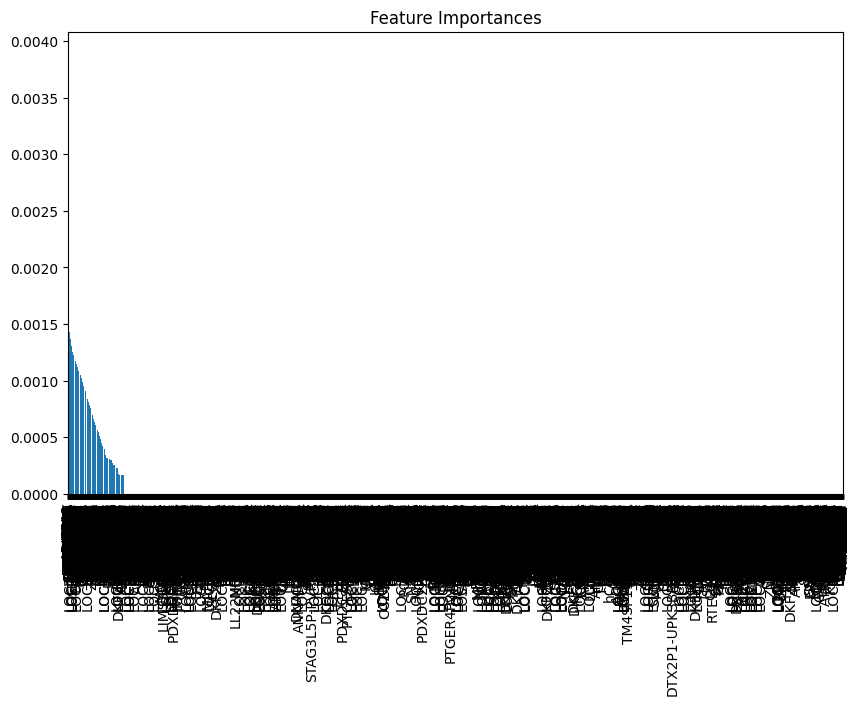

In [24]:
# Plot feature importance
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()